## Keyword Localization at BilagScan

One of the key challenges in invoice processing is localizing and extracting relevant information, e.g., total amount, payment date, etc.
At BilagScan, we rely on keywords amongst other to do such localization. Consider the part of voucher below that contains the keyword "Total Amount"; a reasonable assumption is that the feature representing the total amount on the voucher is "close by".

<img width="500px" src="files/images/TotalAmountLocalization.png" />

We will probabilistically model what it means that a feature is "close by" a target keyword, based on the angle (in degrees) and relative distance between them.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3.distributions.transforms as tr
import pandas as pd
import math

/Users/asal/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We load in realistic angle and distance data from BilagScan

In [2]:
data = pd.read_csv('data/kwanglesdists.csv')

data.head()

,Angle,Distance
0,-0.047,0.278
1,89.410,0.017
2,89.985,0.552
3,0.023,0.887
4,89.866,0.020


If we plot a histogram of the distances, we can see that the total amount values are _usually_ near by their keywords, but not always.

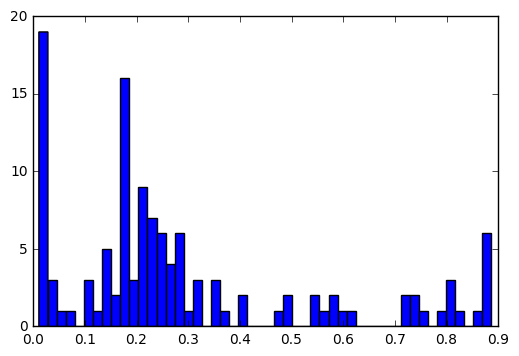

In [3]:
plt.hist(data['Distance'], bins=50);

If we plot a histogram of the angles, we can see that most features are clustered around 0° and 90° away from a keyword.
This is very similar to what our general domain knowledge of vouchers would tell us! 

The total amount value (e.g., "29516,25") is usually to the right or below the keyword (e.g., "Total Amount")

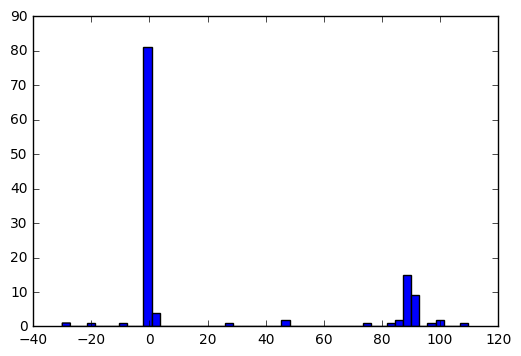

In [4]:
plt.hist(data['Angle'], bins=50);

Using our existing domain knowledge and our real life observed data, we are now ready to construct a probabilistic model. We will rely on  half-Normal distribution for the distance and a _mixture_ of von Mises distributions to model the angles (since the distribution is on the circle as needed).

Formally, the distance part of our model is as follows:
\begin{align*}
\sigma^{-2} &\sim \Gamma(1,1) \\
r &\sim \mathcal{N}^{+}(\sigma)
\end{align*}

We simply use a half-Normal (positive Normal) distribution with standard deviation $\sigma$ drawn from a Gamma prior.
Using a Gamma distribution is the standard way to conditionally describe inverse variance ($\sigma^{-2}$).

The angle part is a bit more complex.
We have to model it as a mixture, because our data is bimodal (centered around two clusters).
Our model is as follows:

\begin{align*}
\mu_{1} &\sim \mathrm{vonMises}(0, 2/\pi) \\
\mu_{2} &\sim \mathrm{vonMises}(\pi/2, 2/\pi) \\
\kappa &\sim \Gamma(1,1) \\
\mathbf{w} &\sim \mathrm{Dir}((1,1)) \\
z &\sim \mathrm{Cat}(\mathbf{w})\\
\theta &\sim \mathrm{vonMises}(\mu_{z}, \kappa) \\
\end{align*}

Modelling a mixture distribution requires us to define the components of each mixture:  $\mu_1$ and $\mu_2$, representing the centers of our peaks in radians, and $\kappa$ representing the dispersion around the centers.

Then we use a categorical variable $z$ to select the index of the component angle comes from. 
We use a Dirichlet prior to the categorical variable, in order to learn the proportions $\mathbf{w}$ of each component. For example, if we fixed $\mathbf{w}$ to the vector $(0.5, 0.5)$ both components would have equal height, and similarly for vector $(0.66, 0.33)$, the first component would be twice as large as the second.


We are now ready to program our formal model using the PyMC3 python framework for probabilistics programming. Note, how we can use our data to train our model to be more realistic, by using the "observed" argument to our target distributions!

In [5]:
with pm.Model() as model:
    sigma_m2 = pm.Gamma('sigma_m2', 1, 1)
    r = pm.HalfNormal('r', tau=sigma_m2, observed=data['Distance'])
    mu_1 = pm.VonMises.dist(mu=0, kappa=2/math.pi)
    mu_2 = pm.VonMises.dist(mu=math.pi/2, kappa=2/math.pi)
    w = pm.Dirichlet('w', np.ones(2))
    mu_z = pm.Mixture('mu_z', w=w, comp_dists=[mu_1, mu_2], transform=tr.circular)
    kappa = pm.Gamma('kappa', 1, 1)
    theta = pm.VonMises('theta', mu=mu_z, kappa=kappa, observed=data['Angle']/180*math.pi)

We can infer a posterior given our data by sampling, which is as easy as calling a method when using PyMC3!

In [6]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [kappa_log__, mu_z_circular__, w_stickbreaking__, sigma_m2_log__]


  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 1/10500 [00:06<19:20:41,  6.63s/it]

  0%|          | 9/10500 [00:06<2:11:55,  1.33it/s] 

  0%|          | 14/10500 [00:06<1:26:03,  2.03it/s]

  0%|          | 22/10500 [00:07<55:34,  3.14it/s]  

  0%|          | 35/10500 [00:07<35:24,  4.92it/s]

  0%|          | 48/10500 [00:07<26:11,  6.65it/s]

  1%|          | 63/10500 [00:07<20:12,  8.61it/s]

  1%|          | 80/10500 [00:07<16:06, 10.78it/s]

  1%|          | 99/10500 [00:07<13:11, 13.15it/s]

  1%|          | 119/10500 [00:07<11:05, 15.60it/s]

  1%|▏         | 146/10500 [00:07<09:08, 18.88it/s]

  2%|▏         | 170/10500 [00:07<07:56, 21.69it/s]

  2%|▏         | 199/10500 [00:07<06:51, 25.05it/s]

  2%|▏         | 222/10500 [00:08<06:12, 27.58it/s]

  2%|▏         | 252/10500 [00:08<05:31, 30.92it/s]

  3%|▎         | 277/10500 [00:08<05:04, 33.56it/s]

  3%|▎         | 304/10500 [00:08<04:40, 36.36it/s]

  3%|▎         | 329/10500 [00:08<04:21, 38.83it/s]

  3%|▎         | 353/10500 [00:08<04:06, 41.08it/s]

  4%|▎         | 377/10500 [00:08<03:53, 43.35it/s]

  4%|▍         | 400/10500 [00:08<03:42, 45.33it/s]

  4%|▍         | 422/10500 [00:08<03:33, 47.18it/s]

  4%|▍         | 449/10500 [00:09<03:22, 49.64it/s]

  5%|▍         | 476/10500 [00:09<03:12, 52.05it/s]

  5%|▍         | 501/10500 [00:09<03:04, 54.18it/s]

  5%|▌         | 525/10500 [00:09<02:57, 56.08it/s]

  5%|▌         | 549/10500 [00:09<02:52, 57.75it/s]

  5%|▌         | 572/10500 [00:09<02:46, 59.50it/s]

  6%|▌         | 596/10500 [00:09<02:41, 61.31it/s]

  6%|▌         | 618/10500 [00:09<02:37, 62.90it/s]

  6%|▌         | 640/10500 [00:09<02:33, 64.35it/s]

  6%|▋         | 661/10500 [00:10<02:29, 65.78it/s]

  6%|▋         | 682/10500 [00:10<02:26, 67.08it/s]

  7%|▋         | 703/10500 [00:10<02:23, 68.46it/s]

  7%|▋         | 725/10500 [00:10<02:19, 69.91it/s]

  7%|▋         | 746/10500 [00:10<02:16, 71.21it/s]

  7%|▋         | 767/10500 [00:10<02:14, 72.35it/s]

  8%|▊         | 791/10500 [00:10<02:11, 73.91it/s]

  8%|▊         | 817/10500 [00:10<02:08, 75.62it/s]

  8%|▊         | 840/10500 [00:10<02:05, 76.98it/s]

  8%|▊         | 862/10500 [00:11<02:03, 77.77it/s]

  8%|▊         | 883/10500 [00:11<02:01, 78.95it/s]

  9%|▊         | 909/10500 [00:11<01:59, 80.54it/s]

  9%|▉         | 941/10500 [00:11<01:55, 82.63it/s]

  9%|▉         | 966/10500 [00:11<01:53, 84.03it/s]

  9%|▉         | 991/10500 [00:11<01:51, 85.13it/s]

 10%|▉         | 1013/10500 [00:11<01:49, 86.28it/s]

 10%|▉         | 1035/10500 [00:11<01:48, 87.30it/s]

 10%|█         | 1057/10500 [00:12<01:47, 87.47it/s]

 10%|█         | 1075/10500 [00:12<01:47, 87.74it/s]

 10%|█         | 1091/10500 [00:12<01:47, 87.73it/s]

 11%|█         | 1107/10500 [00:12<01:46, 88.31it/s]

 11%|█         | 1122/10500 [00:12<01:45, 88.65it/s]

 11%|█         | 1136/10500 [00:12<01:45, 88.83it/s]

 11%|█         | 1149/10500 [00:12<01:45, 89.03it/s]

 11%|█         | 1168/10500 [00:13<01:43, 89.80it/s]

 11%|█▏        | 1183/10500 [00:13<01:43, 90.17it/s]

 11%|█▏        | 1197/10500 [00:13<01:42, 90.53it/s]

 12%|█▏        | 1211/10500 [00:13<01:42, 90.69it/s]

 12%|█▏        | 1228/10500 [00:13<01:41, 91.27it/s]

 12%|█▏        | 1248/10500 [00:13<01:40, 92.06it/s]

 12%|█▏        | 1267/10500 [00:13<01:39, 92.77it/s]

 12%|█▏        | 1284/10500 [00:13<01:38, 93.30it/s]

 12%|█▏        | 1308/10500 [00:13<01:37, 94.30it/s]

 13%|█▎        | 1327/10500 [00:14<01:36, 94.60it/s]

 13%|█▎        | 1345/10500 [00:14<01:36, 95.15it/s]

 13%|█▎        | 1362/10500 [00:14<01:35, 95.63it/s]

 13%|█▎        | 1384/10500 [00:14<01:34, 96.48it/s]

 13%|█▎        | 1404/10500 [00:14<01:33, 97.19it/s]

 14%|█▎        | 1423/10500 [00:14<01:32, 97.67it/s]

 14%|█▎        | 1441/10500 [00:14<01:32, 98.19it/s]

 14%|█▍        | 1459/10500 [00:14<01:31, 98.71it/s]

 14%|█▍        | 1480/10500 [00:14<01:30, 99.44it/s]

 14%|█▍        | 1499/10500 [00:15<01:30, 99.84it/s]

 14%|█▍        | 1517/10500 [00:15<01:29, 100.04it/s]

 15%|█▍        | 1533/10500 [00:15<01:29, 99.92it/s] 

 15%|█▍        | 1549/10500 [00:15<01:29, 100.29it/s]

 15%|█▍        | 1568/10500 [00:15<01:28, 100.86it/s]

 15%|█▌        | 1585/10500 [00:15<01:28, 101.04it/s]

 15%|█▌        | 1600/10500 [00:15<01:28, 100.38it/s]

 15%|█▌        | 1612/10500 [00:16<01:28, 100.30it/s]

 15%|█▌        | 1624/10500 [00:16<01:29, 99.51it/s] 

 16%|█▌        | 1644/10500 [00:16<01:28, 100.11it/s]

 16%|█▌        | 1668/10500 [00:16<01:27, 100.93it/s]

 16%|█▌        | 1688/10500 [00:16<01:26, 101.51it/s]

 16%|█▌        | 1706/10500 [00:16<01:26, 101.94it/s]

 16%|█▋        | 1724/10500 [00:16<01:25, 102.39it/s]

 17%|█▋        | 1742/10500 [00:16<01:25, 102.66it/s]

 17%|█▋        | 1760/10500 [00:17<01:24, 103.11it/s]

 17%|█▋        | 1777/10500 [00:17<01:24, 103.34it/s]

 17%|█▋        | 1799/10500 [00:17<01:23, 103.98it/s]

 17%|█▋        | 1817/10500 [00:17<01:23, 104.12it/s]

 17%|█▋        | 1833/10500 [00:17<01:23, 104.32it/s]

 18%|█▊        | 1849/10500 [00:17<01:22, 104.62it/s]

 18%|█▊        | 1874/10500 [00:17<01:21, 105.43it/s]

 18%|█▊        | 1894/10500 [00:17<01:21, 105.95it/s]

 18%|█▊        | 1913/10500 [00:18<01:21, 105.97it/s]

 18%|█▊        | 1930/10500 [00:18<01:20, 105.89it/s]

 19%|█▊        | 1945/10500 [00:18<01:20, 105.89it/s]

 19%|█▊        | 1965/10500 [00:18<01:20, 106.35it/s]

 19%|█▉        | 1980/10500 [00:18<01:20, 106.37it/s]

 19%|█▉        | 1994/10500 [00:18<01:19, 106.50it/s]

 19%|█▉        | 2012/10500 [00:18<01:19, 106.89it/s]

 19%|█▉        | 2030/10500 [00:18<01:18, 107.28it/s]

 20%|█▉        | 2059/10500 [00:19<01:18, 108.20it/s]

 20%|█▉        | 2083/10500 [00:19<01:17, 108.86it/s]

 20%|██        | 2108/10500 [00:19<01:16, 109.59it/s]

 20%|██        | 2132/10500 [00:19<01:15, 110.25it/s]

 21%|██        | 2155/10500 [00:19<01:15, 110.80it/s]

 21%|██        | 2177/10500 [00:19<01:14, 111.22it/s]

 21%|██        | 2199/10500 [00:19<01:14, 111.77it/s]

 21%|██        | 2223/10500 [00:19<01:13, 112.40it/s]

 21%|██▏       | 2245/10500 [00:19<01:13, 112.93it/s]

 22%|██▏       | 2267/10500 [00:19<01:12, 113.36it/s]

 22%|██▏       | 2288/10500 [00:20<01:12, 113.73it/s]

 22%|██▏       | 2309/10500 [00:20<01:11, 114.21it/s]

 22%|██▏       | 2332/10500 [00:20<01:11, 114.74it/s]

 22%|██▏       | 2353/10500 [00:20<01:10, 115.14it/s]

 23%|██▎       | 2377/10500 [00:20<01:10, 115.73it/s]

 23%|██▎       | 2400/10500 [00:20<01:09, 116.27it/s]

 23%|██▎       | 2429/10500 [00:20<01:08, 117.09it/s]

 23%|██▎       | 2458/10500 [00:20<01:08, 117.91it/s]

 24%|██▎       | 2483/10500 [00:20<01:07, 118.53it/s]

 24%|██▍       | 2508/10500 [00:21<01:07, 118.92it/s]

 24%|██▍       | 2531/10500 [00:21<01:06, 119.43it/s]

 24%|██▍       | 2554/10500 [00:21<01:06, 119.90it/s]

 25%|██▍       | 2577/10500 [00:21<01:05, 120.19it/s]

 25%|██▍       | 2598/10500 [00:21<01:05, 120.53it/s]

 25%|██▍       | 2623/10500 [00:21<01:05, 121.12it/s]

 25%|██▌       | 2646/10500 [00:21<01:04, 121.61it/s]

 25%|██▌       | 2668/10500 [00:21<01:04, 121.94it/s]

 26%|██▌       | 2689/10500 [00:21<01:03, 122.29it/s]

 26%|██▌       | 2710/10500 [00:22<01:03, 122.63it/s]

 26%|██▌       | 2732/10500 [00:22<01:03, 123.05it/s]

 26%|██▌       | 2754/10500 [00:22<01:02, 123.47it/s]

 26%|██▋       | 2775/10500 [00:22<01:02, 123.86it/s]

 27%|██▋       | 2800/10500 [00:22<01:01, 124.41it/s]

 27%|██▋       | 2822/10500 [00:22<01:01, 124.78it/s]

 27%|██▋       | 2849/10500 [00:22<01:01, 125.38it/s]

 27%|██▋       | 2873/10500 [00:22<01:00, 125.82it/s]

 28%|██▊       | 2896/10500 [00:22<01:00, 125.97it/s]

 28%|██▊       | 2918/10500 [00:23<00:59, 126.38it/s]

 28%|██▊       | 2939/10500 [00:23<00:59, 126.71it/s]

 28%|██▊       | 2968/10500 [00:23<00:59, 127.39it/s]

 28%|██▊       | 2991/10500 [00:23<00:58, 127.72it/s]

 29%|██▊       | 3013/10500 [00:23<00:58, 127.78it/s]

 29%|██▉       | 3033/10500 [00:23<00:58, 127.99it/s]

 29%|██▉       | 3060/10500 [00:23<00:57, 128.55it/s]

 29%|██▉       | 3082/10500 [00:23<00:57, 128.94it/s]

 30%|██▉       | 3107/10500 [00:24<00:57, 129.39it/s]

 30%|██▉       | 3129/10500 [00:24<00:56, 129.71it/s]

 30%|███       | 3151/10500 [00:24<00:56, 130.07it/s]

 30%|███       | 3175/10500 [00:24<00:56, 130.50it/s]

 30%|███       | 3199/10500 [00:24<00:55, 130.94it/s]

 31%|███       | 3222/10500 [00:24<00:55, 131.33it/s]

 31%|███       | 3245/10500 [00:24<00:55, 131.73it/s]

 31%|███       | 3268/10500 [00:24<00:54, 132.12it/s]

 31%|███▏      | 3291/10500 [00:24<00:54, 132.30it/s]

 32%|███▏      | 3312/10500 [00:24<00:54, 132.58it/s]

 32%|███▏      | 3333/10500 [00:25<00:53, 132.79it/s]

 32%|███▏      | 3353/10500 [00:25<00:53, 132.93it/s]

 32%|███▏      | 3373/10500 [00:25<00:53, 133.19it/s]

 32%|███▏      | 3403/10500 [00:25<00:53, 133.80it/s]

 33%|███▎      | 3425/10500 [00:25<00:52, 134.08it/s]

 33%|███▎      | 3447/10500 [00:25<00:52, 134.30it/s]

 33%|███▎      | 3468/10500 [00:25<00:52, 134.56it/s]

 33%|███▎      | 3493/10500 [00:25<00:51, 135.00it/s]

 34%|███▎      | 3519/10500 [00:25<00:51, 135.46it/s]

 34%|███▎      | 3542/10500 [00:26<00:51, 135.72it/s]

 34%|███▍      | 3567/10500 [00:26<00:50, 136.16it/s]

 34%|███▍      | 3590/10500 [00:26<00:50, 136.39it/s]

 34%|███▍      | 3615/10500 [00:26<00:50, 136.80it/s]

 35%|███▍      | 3638/10500 [00:26<00:50, 137.06it/s]

 35%|███▍      | 3661/10500 [00:26<00:49, 137.40it/s]

 35%|███▌      | 3683/10500 [00:26<00:49, 137.63it/s]

 35%|███▌      | 3708/10500 [00:26<00:49, 138.01it/s]

 36%|███▌      | 3730/10500 [00:27<00:49, 138.10it/s]

 36%|███▌      | 3750/10500 [00:27<00:48, 138.32it/s]

 36%|███▌      | 3770/10500 [00:27<00:48, 138.53it/s]

 36%|███▌      | 3795/10500 [00:27<00:48, 138.92it/s]

 36%|███▋      | 3824/10500 [00:27<00:47, 139.46it/s]

 37%|███▋      | 3848/10500 [00:27<00:47, 139.72it/s]

 37%|███▋      | 3871/10500 [00:27<00:47, 139.84it/s]

 37%|███▋      | 3892/10500 [00:27<00:47, 140.06it/s]

 37%|███▋      | 3913/10500 [00:27<00:47, 139.83it/s]

 37%|███▋      | 3931/10500 [00:28<00:46, 139.89it/s]

 38%|███▊      | 3951/10500 [00:28<00:46, 140.10it/s]

 38%|███▊      | 3970/10500 [00:28<00:46, 140.26it/s]

 38%|███▊      | 3993/10500 [00:28<00:46, 140.58it/s]

 38%|███▊      | 4013/10500 [00:28<00:46, 140.75it/s]

 38%|███▊      | 4037/10500 [00:28<00:45, 141.06it/s]

 39%|███▊      | 4058/10500 [00:28<00:45, 141.30it/s]

 39%|███▉      | 4081/10500 [00:28<00:45, 141.59it/s]

 39%|███▉      | 4105/10500 [00:28<00:45, 141.91it/s]

 39%|███▉      | 4127/10500 [00:29<00:44, 142.10it/s]

 40%|███▉      | 4148/10500 [00:29<00:44, 141.91it/s]

 40%|███▉      | 4166/10500 [00:29<00:44, 141.94it/s]

 40%|███▉      | 4184/10500 [00:29<00:44, 141.70it/s]

 40%|███▉      | 4199/10500 [00:29<00:44, 141.46it/s]

 40%|████      | 4216/10500 [00:29<00:44, 141.51it/s]

 40%|████      | 4231/10500 [00:29<00:44, 141.23it/s]

 40%|████      | 4246/10500 [00:30<00:44, 141.24it/s]

 41%|████      | 4268/10500 [00:30<00:44, 141.49it/s]

 41%|████      | 4284/10500 [00:30<00:43, 141.47it/s]

 41%|████      | 4300/10500 [00:30<00:43, 141.50it/s]

 41%|████      | 4318/10500 [00:30<00:43, 141.62it/s]

 41%|████▏     | 4343/10500 [00:30<00:43, 141.97it/s]

 42%|████▏     | 4363/10500 [00:30<00:43, 142.14it/s]

 42%|████▏     | 4390/10500 [00:30<00:42, 142.55it/s]

 42%|████▏     | 4412/10500 [00:30<00:42, 142.66it/s]

 42%|████▏     | 4432/10500 [00:31<00:42, 142.66it/s]

 42%|████▏     | 4451/10500 [00:31<00:42, 142.80it/s]

 43%|████▎     | 4470/10500 [00:31<00:42, 142.83it/s]

 43%|████▎     | 4488/10500 [00:31<00:42, 142.94it/s]

 43%|████▎     | 4512/10500 [00:31<00:41, 143.24it/s]

 43%|████▎     | 4532/10500 [00:31<00:41, 143.35it/s]

 43%|████▎     | 4552/10500 [00:31<00:41, 143.51it/s]

 44%|████▎     | 4581/10500 [00:31<00:41, 143.96it/s]

 44%|████▍     | 4603/10500 [00:31<00:40, 144.11it/s]

 44%|████▍     | 4624/10500 [00:32<00:40, 144.14it/s]

 44%|████▍     | 4645/10500 [00:32<00:40, 144.31it/s]

 44%|████▍     | 4665/10500 [00:32<00:40, 144.41it/s]

 45%|████▍     | 4684/10500 [00:32<00:40, 144.34it/s]

 45%|████▍     | 4702/10500 [00:32<00:40, 144.41it/s]

 45%|████▍     | 4719/10500 [00:32<00:40, 144.47it/s]

 45%|████▌     | 4741/10500 [00:32<00:39, 144.66it/s]

 45%|████▌     | 4759/10500 [00:32<00:39, 144.75it/s]

 46%|████▌     | 4781/10500 [00:32<00:39, 144.94it/s]

 46%|████▌     | 4804/10500 [00:33<00:39, 145.19it/s]

 46%|████▌     | 4831/10500 [00:33<00:38, 145.54it/s]

 46%|████▌     | 4853/10500 [00:33<00:38, 145.69it/s]

 46%|████▋     | 4879/10500 [00:33<00:38, 146.03it/s]

 47%|████▋     | 4904/10500 [00:33<00:38, 146.32it/s]

 47%|████▋     | 4927/10500 [00:33<00:38, 146.55it/s]

 47%|████▋     | 4950/10500 [00:33<00:37, 146.62it/s]

 47%|████▋     | 4971/10500 [00:33<00:37, 146.78it/s]

 48%|████▊     | 4992/10500 [00:34<00:37, 146.46it/s]

 48%|████▊     | 5010/10500 [00:34<00:37, 146.05it/s]

 48%|████▊     | 5025/10500 [00:34<00:37, 145.42it/s]

 48%|████▊     | 5037/10500 [00:34<00:37, 145.33it/s]

 48%|████▊     | 5054/10500 [00:34<00:37, 145.37it/s]

 48%|████▊     | 5076/10500 [00:34<00:37, 145.57it/s]

 48%|████▊     | 5092/10500 [00:34<00:37, 145.50it/s]

 49%|████▊     | 5110/10500 [00:35<00:37, 145.59it/s]

 49%|████▉     | 5133/10500 [00:35<00:36, 145.83it/s]

 49%|████▉     | 5151/10500 [00:35<00:36, 145.76it/s]

 49%|████▉     | 5171/10500 [00:35<00:36, 145.89it/s]

 49%|████▉     | 5189/10500 [00:35<00:36, 145.98it/s]

 50%|████▉     | 5212/10500 [00:35<00:36, 146.18it/s]

 50%|████▉     | 5231/10500 [00:35<00:36, 146.27it/s]

 50%|█████     | 5252/10500 [00:35<00:35, 146.44it/s]

 50%|█████     | 5271/10500 [00:35<00:35, 146.54it/s]

 50%|█████     | 5294/10500 [00:36<00:35, 146.75it/s]

 51%|█████     | 5314/10500 [00:36<00:35, 146.85it/s]

 51%|█████     | 5334/10500 [00:36<00:35, 146.85it/s]

 51%|█████     | 5355/10500 [00:36<00:34, 147.00it/s]

 51%|█████     | 5376/10500 [00:36<00:34, 147.10it/s]

 51%|█████▏    | 5395/10500 [00:36<00:34, 146.94it/s]

 52%|█████▏    | 5414/10500 [00:36<00:34, 147.05it/s]

 52%|█████▏    | 5434/10500 [00:36<00:34, 147.19it/s]

 52%|█████▏    | 5459/10500 [00:37<00:34, 147.46it/s]

 52%|█████▏    | 5486/10500 [00:37<00:33, 147.78it/s]

 52%|█████▏    | 5508/10500 [00:37<00:33, 147.94it/s]

 53%|█████▎    | 5535/10500 [00:37<00:33, 148.23it/s]

 53%|█████▎    | 5559/10500 [00:37<00:33, 148.46it/s]

 53%|█████▎    | 5582/10500 [00:37<00:33, 148.47it/s]

 53%|█████▎    | 5609/10500 [00:37<00:32, 148.79it/s]

 54%|█████▎    | 5635/10500 [00:37<00:32, 149.08it/s]

 54%|█████▍    | 5659/10500 [00:37<00:32, 149.16it/s]

 54%|█████▍    | 5688/10500 [00:38<00:32, 149.52it/s]

 54%|█████▍    | 5712/10500 [00:38<00:31, 149.70it/s]

 55%|█████▍    | 5735/10500 [00:38<00:31, 149.86it/s]

 55%|█████▍    | 5758/10500 [00:38<00:31, 149.99it/s]

 55%|█████▌    | 5783/10500 [00:38<00:31, 150.25it/s]

 55%|█████▌    | 5806/10500 [00:38<00:31, 150.21it/s]

 55%|█████▌    | 5826/10500 [00:38<00:31, 150.28it/s]

 56%|█████▌    | 5846/10500 [00:38<00:30, 150.39it/s]

 56%|█████▌    | 5866/10500 [00:38<00:30, 150.43it/s]

 56%|█████▌    | 5891/10500 [00:39<00:30, 150.67it/s]

 56%|█████▋    | 5912/10500 [00:39<00:30, 150.81it/s]

 57%|█████▋    | 5936/10500 [00:39<00:30, 151.04it/s]

 57%|█████▋    | 5965/10500 [00:39<00:29, 151.38it/s]

 57%|█████▋    | 5989/10500 [00:39<00:29, 151.56it/s]

 57%|█████▋    | 6013/10500 [00:39<00:29, 151.77it/s]

 57%|█████▋    | 6036/10500 [00:39<00:29, 151.92it/s]

 58%|█████▊    | 6061/10500 [00:39<00:29, 152.15it/s]

 58%|█████▊    | 6084/10500 [00:39<00:28, 152.31it/s]

 58%|█████▊    | 6107/10500 [00:40<00:28, 152.34it/s]

 58%|█████▊    | 6128/10500 [00:40<00:28, 152.38it/s]

 59%|█████▊    | 6155/10500 [00:40<00:28, 152.67it/s]

 59%|█████▉    | 6177/10500 [00:40<00:28, 152.79it/s]

 59%|█████▉    | 6198/10500 [00:40<00:28, 152.71it/s]

 59%|█████▉    | 6221/10500 [00:40<00:27, 152.88it/s]

 59%|█████▉    | 6242/10500 [00:40<00:27, 152.99it/s]

 60%|█████▉    | 6262/10500 [00:40<00:27, 153.08it/s]

 60%|█████▉    | 6288/10500 [00:41<00:27, 153.34it/s]

 60%|██████    | 6314/10500 [00:41<00:27, 153.59it/s]

 60%|██████    | 6337/10500 [00:41<00:27, 153.77it/s]

 61%|██████    | 6360/10500 [00:41<00:26, 153.93it/s]

 61%|██████    | 6383/10500 [00:41<00:26, 154.07it/s]

 61%|██████    | 6408/10500 [00:41<00:26, 154.29it/s]

 61%|██████    | 6431/10500 [00:41<00:26, 154.35it/s]

 61%|██████▏   | 6456/10500 [00:41<00:26, 154.57it/s]

 62%|██████▏   | 6479/10500 [00:41<00:26, 154.64it/s]

 62%|██████▏   | 6500/10500 [00:42<00:25, 154.69it/s]

 62%|██████▏   | 6525/10500 [00:42<00:25, 154.90it/s]

 62%|██████▏   | 6548/10500 [00:42<00:25, 155.08it/s]

 63%|██████▎   | 6572/10500 [00:42<00:25, 155.27it/s]

 63%|██████▎   | 6595/10500 [00:42<00:25, 155.30it/s]

 63%|██████▎   | 6621/10500 [00:42<00:24, 155.53it/s]

 63%|██████▎   | 6643/10500 [00:42<00:24, 155.63it/s]

 64%|██████▎   | 6669/10500 [00:42<00:24, 155.87it/s]

 64%|██████▍   | 6696/10500 [00:42<00:24, 156.09it/s]

 64%|██████▍   | 6719/10500 [00:43<00:24, 156.22it/s]

 64%|██████▍   | 6743/10500 [00:43<00:24, 156.41it/s]

 64%|██████▍   | 6766/10500 [00:43<00:23, 156.46it/s]

 65%|██████▍   | 6792/10500 [00:43<00:23, 156.68it/s]

 65%|██████▍   | 6815/10500 [00:43<00:23, 156.66it/s]

 65%|██████▌   | 6835/10500 [00:43<00:23, 156.62it/s]

 65%|██████▌   | 6856/10500 [00:43<00:23, 156.74it/s]

 65%|██████▌   | 6876/10500 [00:43<00:23, 156.64it/s]

 66%|██████▌   | 6894/10500 [00:44<00:23, 156.65it/s]

 66%|██████▌   | 6911/10500 [00:44<00:22, 156.61it/s]

 66%|██████▌   | 6928/10500 [00:44<00:22, 156.36it/s]

 66%|██████▌   | 6943/10500 [00:44<00:22, 155.89it/s]

 66%|██████▌   | 6955/10500 [00:44<00:22, 155.09it/s]

 66%|██████▋   | 6966/10500 [00:44<00:22, 154.96it/s]

 66%|██████▋   | 6979/10500 [00:45<00:22, 154.89it/s]

 67%|██████▋   | 6993/10500 [00:45<00:22, 154.85it/s]

 67%|██████▋   | 7006/10500 [00:45<00:22, 154.75it/s]

 67%|██████▋   | 7018/10500 [00:45<00:22, 154.67it/s]

 67%|██████▋   | 7030/10500 [00:45<00:22, 154.39it/s]

 67%|██████▋   | 7041/10500 [00:45<00:22, 154.05it/s]

 67%|██████▋   | 7054/10500 [00:45<00:22, 153.99it/s]

 67%|██████▋   | 7072/10500 [00:45<00:22, 154.04it/s]

 67%|██████▋   | 7085/10500 [00:46<00:22, 153.77it/s]

 68%|██████▊   | 7097/10500 [00:46<00:22, 153.62it/s]

 68%|██████▊   | 7115/10500 [00:46<00:22, 153.68it/s]

 68%|██████▊   | 7129/10500 [00:46<00:21, 153.62it/s]

 68%|██████▊   | 7146/10500 [00:46<00:21, 153.59it/s]

 68%|██████▊   | 7160/10500 [00:46<00:21, 153.20it/s]

 68%|██████▊   | 7175/10500 [00:46<00:21, 153.12it/s]

 68%|██████▊   | 7187/10500 [00:46<00:21, 152.99it/s]

 69%|██████▊   | 7201/10500 [00:47<00:21, 152.92it/s]

 69%|██████▊   | 7213/10500 [00:47<00:21, 152.71it/s]

 69%|██████▉   | 7227/10500 [00:47<00:21, 152.68it/s]

 69%|██████▉   | 7240/10500 [00:47<00:21, 152.62it/s]

 69%|██████▉   | 7252/10500 [00:47<00:21, 152.12it/s]

 69%|██████▉   | 7262/10500 [00:47<00:21, 151.96it/s]

 69%|██████▉   | 7274/10500 [00:47<00:21, 151.88it/s]

 69%|██████▉   | 7286/10500 [00:48<00:21, 151.77it/s]

 70%|██████▉   | 7298/10500 [00:48<00:21, 151.64it/s]

 70%|██████▉   | 7311/10500 [00:48<00:21, 151.59it/s]

 70%|██████▉   | 7332/10500 [00:48<00:20, 151.69it/s]

 70%|███████   | 7350/10500 [00:48<00:20, 151.74it/s]

 70%|███████   | 7365/10500 [00:48<00:20, 151.70it/s]

 70%|███████   | 7380/10500 [00:48<00:20, 151.66it/s]

 70%|███████   | 7395/10500 [00:48<00:20, 151.59it/s]

 71%|███████   | 7409/10500 [00:48<00:20, 151.54it/s]

 71%|███████   | 7430/10500 [00:48<00:20, 151.65it/s]

 71%|███████   | 7446/10500 [00:49<00:20, 151.63it/s]

 71%|███████   | 7463/10500 [00:49<00:20, 151.66it/s]

 71%|███████▏  | 7485/10500 [00:49<00:19, 151.80it/s]

 71%|███████▏  | 7503/10500 [00:49<00:19, 151.83it/s]

 72%|███████▏  | 7521/10500 [00:49<00:19, 151.84it/s]

 72%|███████▏  | 7538/10500 [00:49<00:19, 151.80it/s]

 72%|███████▏  | 7554/10500 [00:49<00:19, 151.74it/s]

 72%|███████▏  | 7575/10500 [00:49<00:19, 151.85it/s]

 72%|███████▏  | 7597/10500 [00:49<00:19, 151.98it/s]

 73%|███████▎  | 7617/10500 [00:50<00:18, 152.06it/s]

 73%|███████▎  | 7638/10500 [00:50<00:18, 152.15it/s]

 73%|███████▎  | 7657/10500 [00:50<00:18, 151.93it/s]

 73%|███████▎  | 7675/10500 [00:50<00:18, 151.97it/s]

 73%|███████▎  | 7695/10500 [00:50<00:18, 152.06it/s]

 73%|███████▎  | 7716/10500 [00:50<00:18, 152.14it/s]

 74%|███████▎  | 7740/10500 [00:50<00:18, 152.30it/s]

 74%|███████▍  | 7765/10500 [00:50<00:17, 152.48it/s]

 74%|███████▍  | 7787/10500 [00:51<00:17, 152.61it/s]

 74%|███████▍  | 7813/10500 [00:51<00:17, 152.80it/s]

 75%|███████▍  | 7839/10500 [00:51<00:17, 153.01it/s]

 75%|███████▍  | 7863/10500 [00:51<00:17, 153.14it/s]

 75%|███████▌  | 7888/10500 [00:51<00:17, 153.31it/s]

 75%|███████▌  | 7911/10500 [00:51<00:16, 153.31it/s]

 76%|███████▌  | 7934/10500 [00:51<00:16, 153.42it/s]

 76%|███████▌  | 7955/10500 [00:51<00:16, 153.32it/s]

 76%|███████▌  | 7978/10500 [00:51<00:16, 153.47it/s]

 76%|███████▌  | 7998/10500 [00:52<00:16, 153.52it/s]

 76%|███████▋  | 8023/10500 [00:52<00:16, 153.67it/s]

 77%|███████▋  | 8046/10500 [00:52<00:15, 153.79it/s]

 77%|███████▋  | 8076/10500 [00:52<00:15, 154.07it/s]

 77%|███████▋  | 8100/10500 [00:52<00:15, 154.06it/s]

 77%|███████▋  | 8125/10500 [00:52<00:15, 154.23it/s]

 78%|███████▊  | 8149/10500 [00:52<00:15, 154.36it/s]

 78%|███████▊  | 8172/10500 [00:52<00:15, 154.48it/s]

 78%|███████▊  | 8194/10500 [00:53<00:14, 154.55it/s]

 78%|███████▊  | 8215/10500 [00:53<00:14, 154.63it/s]

 78%|███████▊  | 8238/10500 [00:53<00:14, 154.75it/s]

 79%|███████▊  | 8262/10500 [00:53<00:14, 154.91it/s]

 79%|███████▉  | 8284/10500 [00:53<00:14, 155.02it/s]

 79%|███████▉  | 8306/10500 [00:53<00:14, 155.03it/s]

 79%|███████▉  | 8329/10500 [00:53<00:13, 155.17it/s]

 80%|███████▉  | 8350/10500 [00:53<00:13, 155.24it/s]

 80%|███████▉  | 8376/10500 [00:53<00:13, 155.42it/s]

 80%|████████  | 8400/10500 [00:53<00:13, 155.57it/s]

 80%|████████  | 8425/10500 [00:54<00:13, 155.74it/s]

 80%|████████  | 8448/10500 [00:54<00:13, 155.80it/s]

 81%|████████  | 8470/10500 [00:54<00:13, 155.91it/s]

 81%|████████  | 8492/10500 [00:54<00:12, 156.01it/s]

 81%|████████  | 8518/10500 [00:54<00:12, 156.19it/s]

 81%|████████▏ | 8541/10500 [00:54<00:12, 156.25it/s]

 82%|████████▏ | 8563/10500 [00:54<00:12, 156.30it/s]

 82%|████████▏ | 8584/10500 [00:54<00:12, 156.35it/s]

 82%|████████▏ | 8604/10500 [00:55<00:12, 156.39it/s]

 82%|████████▏ | 8624/10500 [00:55<00:11, 156.45it/s]

 82%|████████▏ | 8643/10500 [00:55<00:11, 156.49it/s]

 82%|████████▏ | 8662/10500 [00:55<00:11, 156.32it/s]

 83%|████████▎ | 8679/10500 [00:55<00:11, 156.24it/s]

 83%|████████▎ | 8694/10500 [00:55<00:11, 156.20it/s]

 83%|████████▎ | 8711/10500 [00:55<00:11, 156.22it/s]

 83%|████████▎ | 8728/10500 [00:55<00:11, 156.24it/s]

 83%|████████▎ | 8746/10500 [00:55<00:11, 156.26it/s]

 83%|████████▎ | 8763/10500 [00:56<00:11, 156.28it/s]

 84%|████████▎ | 8780/10500 [00:56<00:11, 156.28it/s]

 84%|████████▍ | 8798/10500 [00:56<00:10, 156.31it/s]

 84%|████████▍ | 8815/10500 [00:56<00:10, 156.22it/s]

 84%|████████▍ | 8831/10500 [00:56<00:10, 156.02it/s]

 84%|████████▍ | 8847/10500 [00:56<00:10, 156.02it/s]

 84%|████████▍ | 8862/10500 [00:56<00:10, 155.96it/s]

 85%|████████▍ | 8880/10500 [00:56<00:10, 155.99it/s]

 85%|████████▍ | 8907/10500 [00:57<00:10, 156.19it/s]

 85%|████████▌ | 8935/10500 [00:57<00:10, 156.39it/s]

 85%|████████▌ | 8956/10500 [00:57<00:09, 156.47it/s]

 86%|████████▌ | 8979/10500 [00:57<00:09, 156.57it/s]

 86%|████████▌ | 9000/10500 [00:57<00:09, 156.62it/s]

 86%|████████▌ | 9020/10500 [00:57<00:09, 156.67it/s]

 86%|████████▌ | 9040/10500 [00:57<00:09, 156.64it/s]

 86%|████████▋ | 9058/10500 [00:57<00:09, 156.53it/s]

 86%|████████▋ | 9078/10500 [00:57<00:09, 156.59it/s]

 87%|████████▋ | 9095/10500 [00:58<00:08, 156.58it/s]

 87%|████████▋ | 9113/10500 [00:58<00:08, 156.60it/s]

 87%|████████▋ | 9131/10500 [00:58<00:08, 156.64it/s]

 87%|████████▋ | 9155/10500 [00:58<00:08, 156.77it/s]

 87%|████████▋ | 9181/10500 [00:58<00:08, 156.95it/s]

 88%|████████▊ | 9202/10500 [00:58<00:08, 156.93it/s]

 88%|████████▊ | 9225/10500 [00:58<00:08, 157.06it/s]

 88%|████████▊ | 9246/10500 [00:58<00:07, 157.08it/s]

 88%|████████▊ | 9266/10500 [00:58<00:07, 157.08it/s]

 88%|████████▊ | 9287/10500 [00:59<00:07, 157.17it/s]

 89%|████████▊ | 9307/10500 [00:59<00:07, 157.18it/s]

 89%|████████▉ | 9326/10500 [00:59<00:07, 157.08it/s]

 89%|████████▉ | 9350/10500 [00:59<00:07, 157.21it/s]

 89%|████████▉ | 9371/10500 [00:59<00:07, 157.28it/s]

 89%|████████▉ | 9390/10500 [00:59<00:07, 157.29it/s]

 90%|████████▉ | 9409/10500 [00:59<00:06, 157.31it/s]

 90%|████████▉ | 9432/10500 [00:59<00:06, 157.43it/s]

 90%|█████████ | 9459/10500 [01:00<00:06, 157.62it/s]

 90%|█████████ | 9486/10500 [01:00<00:06, 157.80it/s]

 91%|█████████ | 9509/10500 [01:00<00:06, 157.70it/s]

 91%|█████████ | 9529/10500 [01:00<00:06, 157.52it/s]

 91%|█████████ | 9546/10500 [01:00<00:06, 157.47it/s]

 91%|█████████ | 9569/10500 [01:00<00:05, 157.59it/s]

 91%|█████████▏| 9590/10500 [01:00<00:05, 157.67it/s]

 92%|█████████▏| 9617/10500 [01:00<00:05, 157.86it/s]

 92%|█████████▏| 9639/10500 [01:01<00:05, 157.78it/s]

 92%|█████████▏| 9659/10500 [01:01<00:05, 157.85it/s]

 92%|█████████▏| 9679/10500 [01:01<00:05, 157.84it/s]

 92%|█████████▏| 9702/10500 [01:01<00:05, 157.96it/s]

 93%|█████████▎| 9724/10500 [01:01<00:04, 158.05it/s]

 93%|█████████▎| 9745/10500 [01:01<00:04, 158.08it/s]

 93%|█████████▎| 9767/10500 [01:01<00:04, 158.18it/s]

 93%|█████████▎| 9793/10500 [01:01<00:04, 158.30it/s]

 94%|█████████▎| 9820/10500 [01:01<00:04, 158.46it/s]

 94%|█████████▍| 9846/10500 [01:02<00:04, 158.62it/s]

 94%|█████████▍| 9874/10500 [01:02<00:03, 158.81it/s]

 94%|█████████▍| 9901/10500 [01:02<00:03, 158.98it/s]

 95%|█████████▍| 9930/10500 [01:02<00:03, 159.19it/s]

 95%|█████████▍| 9961/10500 [01:02<00:03, 159.42it/s]

 95%|█████████▌| 9989/10500 [01:02<00:03, 159.49it/s]

 95%|█████████▌| 10020/10500 [01:02<00:03, 159.73it/s]

 96%|█████████▌| 10047/10500 [01:02<00:02, 159.90it/s]

 96%|█████████▌| 10074/10500 [01:02<00:02, 159.95it/s]

 96%|█████████▌| 10099/10500 [01:03<00:02, 160.08it/s]

 96%|█████████▋| 10131/10500 [01:03<00:02, 160.33it/s]

 97%|█████████▋| 10161/10500 [01:03<00:02, 160.55it/s]

 97%|█████████▋| 10189/10500 [01:03<00:01, 160.72it/s]

 97%|█████████▋| 10217/10500 [01:03<00:01, 160.91it/s]

 98%|█████████▊| 10247/10500 [01:03<00:01, 161.11it/s]

 98%|█████████▊| 10275/10500 [01:03<00:01, 161.28it/s]

 98%|█████████▊| 10306/10500 [01:03<00:01, 161.51it/s]

 98%|█████████▊| 10335/10500 [01:03<00:01, 161.69it/s]

 99%|█████████▊| 10363/10500 [01:04<00:00, 161.86it/s]

 99%|█████████▉| 10391/10500 [01:04<00:00, 161.99it/s]

 99%|█████████▉| 10420/10500 [01:04<00:00, 162.18it/s]

 99%|█████████▉| 10447/10500 [01:04<00:00, 162.28it/s]

100%|█████████▉| 10476/10500 [01:04<00:00, 162.48it/s]

100%|██████████| 10500/10500 [01:04<00:00, 162.57it/s]

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma_m2,6.117376,0.776391,0.004738,4.641888,7.659168,26019.195495,0.999995
w__0,0.531432,0.284202,0.001582,0.063755,0.999903,28570.418449,0.999956
w__1,0.468568,0.284202,0.001582,0.000097,0.936245,28570.418449,0.999956
mu_z,0.352652,0.064662,0.000383,0.224681,0.477722,27204.155456,0.999950
kappa,2.548164,0.280507,0.001926,2.007571,3.097207,20191.200354,0.999955


Finally, we can try to draw random samples from our posterior distributions to see how it predicts the angles and distances of new features.

In [8]:
ppc = pm.sample_ppc(trace, samples=1000, model=model)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<25:49,  1.55s/it]

 10%|▉         | 98/1000 [00:01<00:15, 59.34it/s]

 20%|█▉        | 196/1000 [00:01<00:07, 111.88it/s]

 28%|██▊       | 280/1000 [00:01<00:04, 151.14it/s]

 34%|███▍      | 341/1000 [00:01<00:03, 174.43it/s]

 42%|████▏     | 416/1000 [00:02<00:02, 202.42it/s]

 50%|████▉     | 498/1000 [00:02<00:02, 230.99it/s]

 57%|█████▋    | 568/1000 [00:02<00:01, 251.36it/s]

 64%|██████▎   | 637/1000 [00:02<00:01, 268.07it/s]

 70%|███████   | 703/1000 [00:02<00:01, 272.78it/s]

 78%|███████▊  | 776/1000 [00:02<00:00, 285.52it/s]

 83%|████████▎ | 831/1000 [00:02<00:00, 284.45it/s]

 88%|████████▊ | 878/1000 [00:03<00:00, 270.27it/s]

 92%|█████████▏| 916/1000 [00:03<00:00, 273.54it/s]

 99%|█████████▉| 991/1000 [00:03<00:00, 282.56it/s]

100%|██████████| 1000/1000 [00:03<00:00, 279.23it/s]

First, we draw the distances.

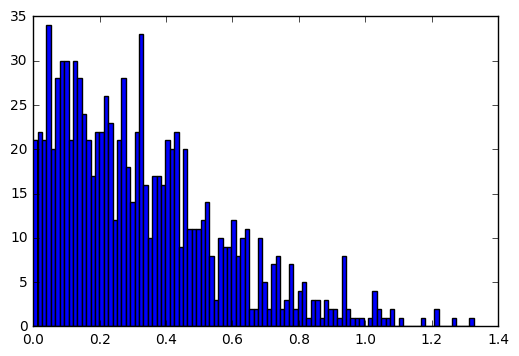

In [9]:
plt.hist([r for r in ppc['r']], bins=100);

Then we draw the angles

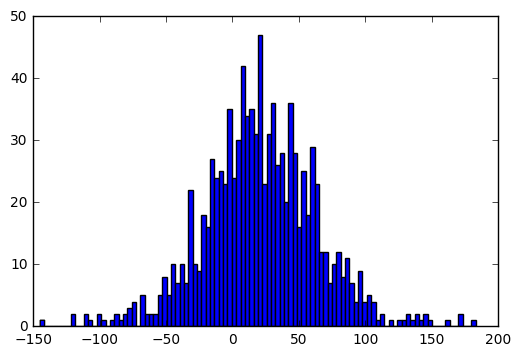

In [10]:
plt.hist([theta for theta in (ppc['theta']*180/math.pi)], bins=100);